# Recommender System Demonstration Notebook
## Topics covered:
## 1. Data preparation (toy MovieLens-style dataset)
### 2. Collaborative Filtering
    - User-based and Item-based
    - Similarity metrics: cosine similarity, Pearson correlation
### 3. Content-Based Filtering
    - TF-IDF on item descriptions / genres
    - Simple dense embeddings via TruncatedSVD
    - Feature engineering for recommendation models
### 4. Hybrid Recommender Systems
    - Combine collaborative + content-based scores
    - Matrix factorization (SVD)
    - Neural Collaborative Filtering (simple MLP with Keras)


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tensorflow as tf
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

2025-10-23 14:53:02.887248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761231183.069201      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761231183.132803      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 0. Take a small toy dataset (MovieLens-like)



In [2]:
# Load dataset
movies = pd.read_csv('/kaggle/input/movie-recommendation-system/movies.csv')
ratings = pd.read_csv('/kaggle/input/movie-recommendation-system/ratings.csv')

print(movies.head())
print(ratings.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510


In [3]:
# Basic preprocessing
ratings = ratings.dropna(subset=['userId', 'movieId', 'rating'])
ratings['userId'] = ratings['userId'].astype(int)
ratings['movieId'] = ratings['movieId'].astype(int)

# Merge ratings with movie titles
data = ratings.merge(movies, on='movieId')

# Create smaller subset for demo (optional)
sample_users = data['userId'].drop_duplicates().sample(500, random_state=42)
data_small = data[data['userId'].isin(sample_users)]


# 1. Collaborative Filtering
## 1.1 User-based collaborative filtering (neighborhood-based)
We'll compute user-user similarities using cosine and Pearson, then predict ratings

In [4]:
# Build sparse matrix efficiently
from scipy.sparse import coo_matrix

user_mapper = {u: i for i, u in enumerate(data_small['userId'].unique())}
movie_mapper = {m: i for i, m in enumerate(data_small['movieId'].unique())}

user_inv_mapper = {i: u for u, i in user_mapper.items()}
movie_inv_mapper = {i: m for m, i in movie_mapper.items()}

user_index = [user_mapper[u] for u in data_small['userId']]
movie_index = [movie_mapper[m] for m in data_small['movieId']]

ratings_matrix = coo_matrix(
    (data_small['rating'], (user_index, movie_index))
).tocsr()

# Compute similarity
user_similarity = cosine_similarity(ratings_matrix)
print("User similarity matrix shape:", user_similarity.shape)

User similarity matrix shape: (500, 500)


In [5]:
# Recommend movies to a user
def recommend_movies_user_based(user_id, top_n=5):
    user_idx = user_mapper[user_id]
    sim_scores = list(enumerate(user_similarity[user_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:11]
    
    sim_users = [user_inv_mapper[i] for i, _ in sim_scores]
    recs = data_small[data_small['userId'].isin(sim_users)] \
        .groupby('movieId')['rating'].mean() \
        .sort_values(ascending=False) \
        .head(top_n)
    
    return movies[movies['movieId'].isin(recs.index)][['title']]

recommend_movies_user_based(user_id=data_small['userId'].iloc[0])

,title
477,Killing Zoe (1994)
585,"Silence of the Lambs, The (1991)"
651,Fear (1996)
1318,"Mirror Has Two Faces, The (1996)"
1322,Shine (1996)


## 1.2 Item-based collaborative filtering
Compute item-item similarities and predict using similar items a user liked

Build item-user matrix and compute item-item cosine similarity

In [6]:
item_similarity = cosine_similarity(ratings_matrix.T)
print("Item similarity matrix shape:", item_similarity.shape)

def recommend_similar_movies(movie_title, top_n=5):
    movie_id = movies[movies['title'].str.contains(movie_title, case=False, na=False)].iloc[0]['movieId']
    if movie_id not in movie_mapper:
        return "Movie not found in sample data."
    movie_idx = movie_mapper[movie_id]
    sim_scores = list(enumerate(item_similarity[movie_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    sim_movies = [movie_inv_mapper[i] for i, _ in sim_scores]
    return movies[movies['movieId'].isin(sim_movies)][['title']]

recommend_similar_movies("Toy Story")

Item similarity matrix shape: (8698, 8698)


,title
257,Star Wars: Episode IV - A New Hope (1977)
351,Forrest Gump (1994)
637,Mission: Impossible (1996)
764,Independence Day (a.k.a. ID4) (1996)
3021,Toy Story 2 (1999)


# 2. Content-Based Filtering
We'll use TF-IDF over movie titles/genres/descriptions and compute item similarity.
Then recommend items similar to ones the user liked.


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# TF-IDF representation of genres
tfidf = TfidfVectorizer(token_pattern=r'[^|]+')
tfidf_matrix = tfidf.fit_transform(movies['genres'].fillna(''))

# Use Nearest Neighbors (cosine distance)
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(tfidf_matrix)

def recommend_by_genre(title, top_n=5):
    # find index of the movie
    indices = movies[movies['title'].str.contains(title, case=False, na=False)].index
    if len(indices) == 0:
        return "Movie not found."
    idx = indices[0]

    # query top_n+1 neighbors (including itself)
    distances, indices = nn.kneighbors(tfidf_matrix[idx], n_neighbors=top_n+1)
    
    # exclude the first one (the movie itself)
    sim_indices = indices[0][1:]
    return movies.iloc[sim_indices][['title', 'genres']]

recommend_by_genre("Matrix")

,title,genres
3429,Predator (1987),Action|Sci-Fi|Thriller
42131,Deep Core (2000),Action|Sci-Fi|Thriller
36305,Garm Wars: The Last Druid (2014),Action|Sci-Fi|Thriller
45387,The Time Shifters (1999),Action|Sci-Fi|Thriller
56298,Cold Harvest (1998),Action|Sci-Fi|Thriller


# 3. Hybrid: combine collaborative + content-based
We'll compute normalized collaborative score and content score and take weighted sum.

In [8]:
def hybrid_recommend(title, alpha=0.5, top_n=5):
    # find movie index in movies DataFrame
    match = movies[movies['title'].str.contains(title, case=False, na=False)]
    if match.empty:
        return "Movie not found."
    idx = match.index[0]
    movie_id = movies.iloc[idx]['movieId']

    # content similarity vector (full movie list)
    content_scores = np.zeros(len(movies))
    try:
        _, indices = nn.kneighbors(tfidf_matrix[idx], n_neighbors=top_n+20)
        for i in indices[0]:
            content_scores[i] = 1.0  # or use cosine distance weighting if you want
    except Exception as e:
        return f"Error in content similarity: {e}"

    # check if movie exists in collaborative map
    if movie_id not in movie_mapper:
        # fallback: content only
        return recommend_by_genre(title, top_n)
    
    # collaborative item similarity (subset only)
    movie_idx = movie_mapper[movie_id]
    item_scores = item_similarity[movie_idx]

    # align lengths by mapping collaborative movieIds back to global movie indices
    subset_movie_ids = [movie_inv_mapper[i] for i in range(len(item_scores))]
    content_reduced = np.array([
        content_scores[movies[movies['movieId'] == mid].index[0]]
        if mid in movies['movieId'].values else 0
        for mid in subset_movie_ids
    ])

    # combine normalized scores safely
    hybrid_scores = alpha * content_reduced + (1 - alpha) * item_scores
    top_indices = np.argsort(hybrid_scores)[::-1][1:top_n+1]

    rec_movie_ids = [subset_movie_ids[i] for i in top_indices]
    return movies[movies['movieId'].isin(rec_movie_ids)][['title', 'genres']]

# Try it
hybrid_recommend("Toy Story")


,title,genres
3912,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
4780,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
11604,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy
20015,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy
43614,Moana (2016),Adventure|Animation|Children|Comedy|Fantasy


# 4. Matrix Factorization: SVD on user-item matrix
We'll create a simple matrix factorization using TruncatedSVD on the user-item matrix.

In [9]:
# Using TruncatedSVD on sparse matrix
svd = TruncatedSVD(n_components=50, random_state=42)
latent_matrix = svd.fit_transform(ratings_matrix)
print("Latent feature matrix shape:", latent_matrix.shape)

# Movie embeddings
movie_latent = svd.components_.T
def recommend_svd(movie_title, top_n=5):
    movie_id = movies[movies['title'].str.contains(movie_title, case=False, na=False)].iloc[0]['movieId']
    if movie_id not in movie_mapper:
        return "Movie not found in sample data."
    movie_idx = movie_mapper[movie_id]
    sim_scores = cosine_similarity([movie_latent[movie_idx]], movie_latent)[0]
    top_indices = np.argsort(sim_scores)[::-1][1:top_n+1]
    return movies.iloc[top_indices][['title']]

recommend_svd("Toy Story")

Latent feature matrix shape: (500, 50)


,title
612,Scream of Stone (Cerro Torre: Schrei aus Stein...
6738,Charlotte Sometimes (2002)
198,"Tie That Binds, The (1995)"
773,"I, the Worst of All (Yo, la peor de todas) (1990)"
608,"Aristocats, The (1970)"


# 5. Neural Collaborative Filtering (simple MLP)
We'll prepare user and item id mappings, train a small MLP to predict ratings.
This is a minimal educational example (not tuned for production).


In [10]:
import tensorflow as tf
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def rating_accuracy(y_true, y_pred):
    # round predictions to nearest integer rating (e.g., 1–5 scale)
    y_pred_rounded = K.round(y_pred)
    return K.mean(K.cast(K.equal(y_true, y_pred_rounded), tf.float32))

In [11]:
from tensorflow.keras import layers, models, regularizers, optimizers


def build_improved_ncf(n_users, n_movies, n_factors=64, dense_layers=[128, 64, 32], dropout_rate=0.3):
    user_input = layers.Input(shape=(1,))
    movie_input = layers.Input(shape=(1,))

    user_emb = layers.Embedding(n_users, n_factors, embeddings_initializer='he_normal')(user_input)
    movie_emb = layers.Embedding(n_movies, n_factors, embeddings_initializer='he_normal')(movie_input)

    user_vec = layers.Flatten()(user_emb)
    movie_vec = layers.Flatten()(movie_emb)

    # Concatenate user & movie representations
    x = layers.Concatenate()([user_vec, movie_vec])

    # Fully connected layers with BatchNorm + Dropout
    for units in dense_layers:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)

    out = layers.Dense(1, activation='linear')(x)  # rating regression

    model = models.Model([user_input, movie_input], out)
    model.compile(optimizer='adam', 
                  loss='mse', 
                  metrics=[rmse, 'mae', rating_accuracy])
    return model



In [12]:
# Prepare data (same as before)
train, test = train_test_split(data_small, test_size=0.2, random_state=42)
train_u = np.array([user_mapper[u] for u in train['userId']])
train_m = np.array([movie_mapper[m] for m in train['movieId']])
test_u = np.array([user_mapper[u] for u in test['userId']])
test_m = np.array([movie_mapper[m] for m in test['movieId']])

# Build and train
n_users = len(user_mapper)
n_movies = len(movie_mapper)

model = build_improved_ncf(n_users, n_movies)
model.summary()

I0000 00:00:1761231217.257417      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 64)     │     32,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 64)     │    556,672 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 64)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 616,449 (2.35 MB)

 Trainable params: 616,001 (2.35 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
history = model.fit([train_u, train_m], train['rating'],
                    validation_data=([test_u, test_m], test['rating']),
                    epochs=20, batch_size=128, verbose=1)

Epoch 1/20


I0000 00:00:1761231222.969045      59 service.cc:148] XLA service 0x7fbca8016340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761231222.969496      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761231223.377151      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


 56/526 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14.0417 - mae: 3.3884 - rating_accuracy: 0.0247 - rmse: 3.7443

I0000 00:00:1761231225.847998      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


526/526 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 8.9640 - mae: 2.5689 - rating_accuracy: 0.0635 - rmse: 2.8889 - val_loss: 1.0471 - val_mae: 0.8290 - val_rating_accuracy: 0.2422 - val_rmse: 1.0215
Epoch 2/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.6829 - mae: 1.0251 - rating_accuracy: 0.2127 - rmse: 1.2933 - val_loss: 0.9163 - val_mae: 0.7568 - val_rating_accuracy: 0.2836 - val_rmse: 0.9553
Epoch 3/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2426 - mae: 0.8785 - rating_accuracy: 0.2454 - rmse: 1.1118 - val_loss: 0.8409 - val_mae: 0.7162 - val_rating_accuracy: 0.2997 - val_rmse: 0.9149
Epoch 4/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0012 - mae: 0.7902 - rating_accuracy: 0.2728 - rmse: 0.9985 - val_loss: 0.8135 - val_mae: 0.7005 - val_rating_accuracy: 0.3072 - val_rmse: 0.8995
Epoch 5/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8952 - mae: 0.7425 - rating_accuracy: 0.2923 - rmse: 0.9439 - val_loss: 0.7974 - val_mae: 0.6912 - val_rating_accur

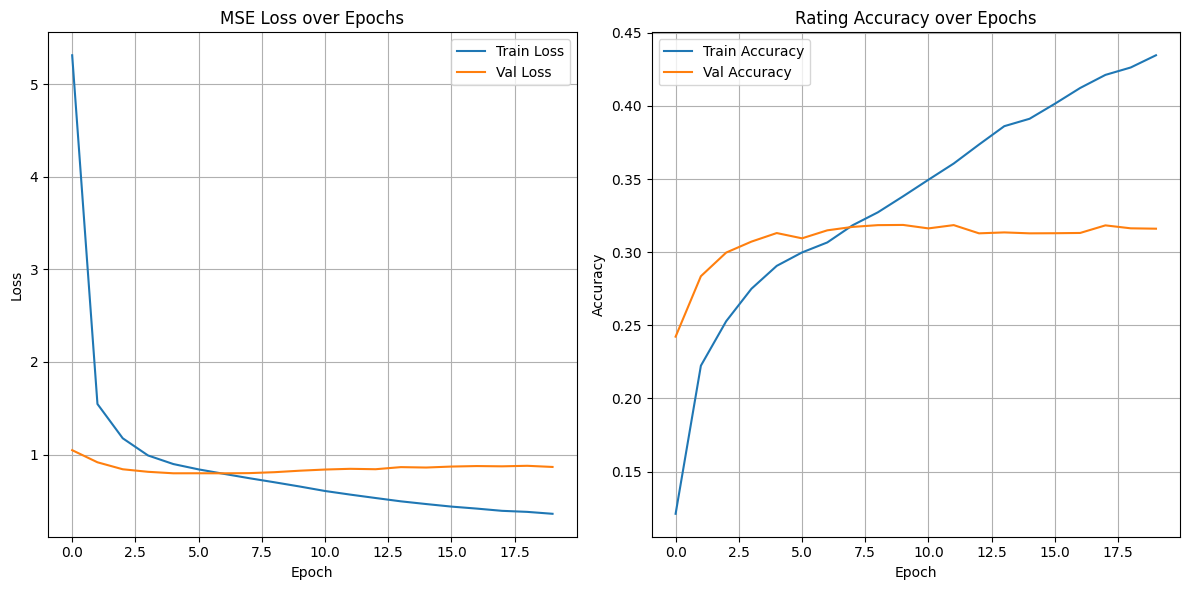

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MSE Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['rating_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_rating_accuracy'], label='Val Accuracy')
plt.title('Rating Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
results = model.evaluate([test_u, test_m], test['rating'], verbose=0)
print(f"Test MSE:  {results[0]:.4f}")
print(f"Test RMSE: {results[1]:.4f}")
print(f"Test MAE:  {results[2]:.4f}")
print(f"Test Accuracy: {results[3]*100:.2f}%")

Test MSE:  0.8659
Test RMSE: 0.9200
Test MAE:  0.7086
Test Accuracy: 31.61%


- For content-based features, consider richer features: text embeddings from transformer models, image embeddings, user profiles.
- Evaluation: use metrics such as RMSE for rating prediction and Precision@K / Recall@K / NDCG for top-N recommendation.
- Production considerations: scalability (approx nearest neighbors, hashing), handling cold-start, diversity, serendipity, and online learning.